In [ ]:
# import comet_ml

import dotenv 
dotenv.load_dotenv()
from transformers import (
    BertConfig,
    BertForMaskedLM,
    PreTrainedTokenizerFast,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from datasets import load_from_disk


tokenizer = PreTrainedTokenizerFast.from_pretrained("dataset/tokenizer/wp_tokenizer_31000")

SyntaxError: invalid syntax (557759733.py, line 2)

In [39]:
tokenized_dataset = load_from_disk("dataset/huggingface/standard_hex_tokenized_31000")
# 拆分验证集和测试集
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
valid_test_split = split_dataset["test"].train_test_split(test_size=0.5, seed=42)
tokenized_dataset = DatasetDict(
    {
        "train": split_dataset["train"],
        "valid": valid_test_split["train"],
        "test": valid_test_split["test"],
    }
)

In [41]:
def compute_unk_ratio(example):
    unk_id = tokenizer.unk_token_id
    input_ids = example["input_ids"]
    total = len(input_ids)
    unk_count = sum(1 for x in input_ids if x == unk_id)
    return {"unk_ratio": unk_count / total if total > 0 else 0}


unk_stats = tokenized_dataset["valid"].map(compute_unk_ratio)

Map:   0%|          | 0/131799 [00:00<?, ? examples/s]

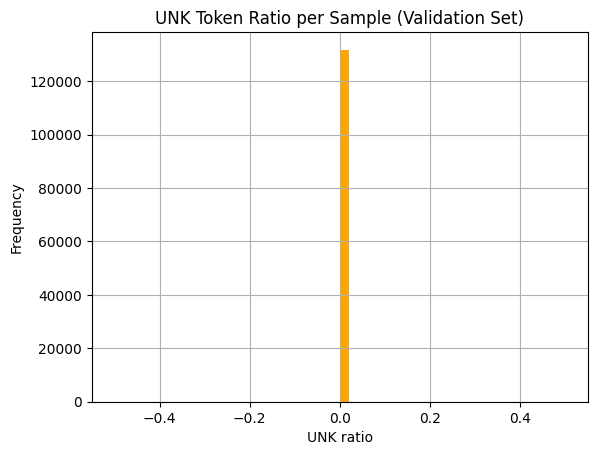

In [42]:
import matplotlib.pyplot as plt

ratios = [ex["unk_ratio"] for ex in unk_stats]

plt.hist(ratios, bins=50, color="orange")
plt.title("UNK Token Ratio per Sample (Validation Set)")
plt.xlabel("UNK ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
df = dataset["train"].to_pandas()
lengths = [len(tokenizer.encode(text)) for text in df["text"].sample(1000)]
print(max(lengths))
print(min(lengths))
print(sum(lengths) / len(lengths))

In [15]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=64,
        padding="max_length",
    )
tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

Map:   0%|          | 0/1054390 [00:00<?, ? examples/s]

Map:   0%|          | 0/131798 [00:00<?, ? examples/s]

Map:   0%|          | 0/131800 [00:00<?, ? examples/s]

In [30]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1054390
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 131798
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 131800
    })
})


In [ ]:

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)


In [25]:


config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=256,
    num_hidden_layers=6,
    num_attention_heads=4,
    intermediate_size=3072,
    max_position_embeddings=512,
    type_vocab_size=1
)
model = BertForMaskedLM(config)

In [32]:


training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_dir="./output/logs",
    logging_steps=100,
    report_to=["mlflow", "comet_ml"],
    run_name="[LC1]bert-mlm-pretraining:v0.1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
)

In [33]:
trainer.train() 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mythezone/general/312c2a1e65184820bc29b0a3e505a040

COMET INFO: An experiment with the same configuration options is already running and will be reused.
/home/zhongmuyao/miniconda3/envs/hf/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


/home/zhongmuyao/miniconda3/envs/hf/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zhongmuyao/miniconda3/envs/hf/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [34]:
import argparse
import comet_ml
from transformers import (
    BertConfig,
    BertForMaskedLM,
    PreTrainedTokenizerFast,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset, DatasetDict, load_from_disk
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["COMET_API_KEY"] = "yJJTSjgwXMbbO1FgvP5gxNLWr"

tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="dataset/tokenizer/wp_tokenizer.json"
)
# 显式注册特殊 token
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"  # 如果有的话
tokenizer.sep_token = "[SEP]"  # 如果有的话
tokenizer.mask_token = "[MASK]"  # 如果用于MLM，建议定义
tokenizer.unk_token = "[UNK]"


dataset = load_from_disk("dataset/huggingface/standard_hex")


def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=64,
        padding="max_length",
    )


tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_datasets.save_to_disk("dataset/huggingface/standard_hex_tokenized")

Map:   0%|          | 0/131798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1054390 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/131798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/131800 [00:00<?, ? examples/s]

In [35]:
experiment = comet_ml.Experiment(
    api_key=os.environ["COMET_API_KEY"],
    project_name="bert-mlm-pretraining",
    workspace="your_workspace",  # 替换为你的工作区名称
)
experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : [LC1]bert-mlm-pretraining:v0.1
COMET INFO:     url                   : https://www.comet.com/mythezone/general/312c2a1e65184820bc29b0a3e505a040
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [11]               : (0.015174506828528073, 0.1669195751138088)
COMET INFO:     grad_norm                : 0.0
COMET INFO:     learning_rate [11]       : (4.916616084977239e-05, 4.992488619119879e-05)
COMET INFO:     loss                     : 0.0
COMET INFO:     train/epoch [11]         : (0.015174506828528073, 0.1669195751138088)
C